In [141]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import xgboost as xgb
import optuna

from collections import Counter
import warnings

warnings.filterwarnings("ignore")

Lasso ile feature selection yapıp sonrasında xgboost, lightgbm gibi tree modellerini deneyeceğim.

ALso, try out dim. reduction techniques.

In [58]:
def name_of_object(arg):
    # check __name__ attribute (functions)
    try:
        return arg.__name__
    except AttributeError:
        pass

    for name, value in globals().items():
        if value is arg and not name.startswith('_'):
            return name


def report_log_loss(obj, true, pred_probs):
    print(f"log_loss of {name_of_object(obj)} for validation set {log_loss(true, pred_probs):.4f}")

In [59]:
train = pd.read_csv("task_2022/train_data_swc.csv")
test = pd.read_csv("task_2022/test_data_swc.csv")

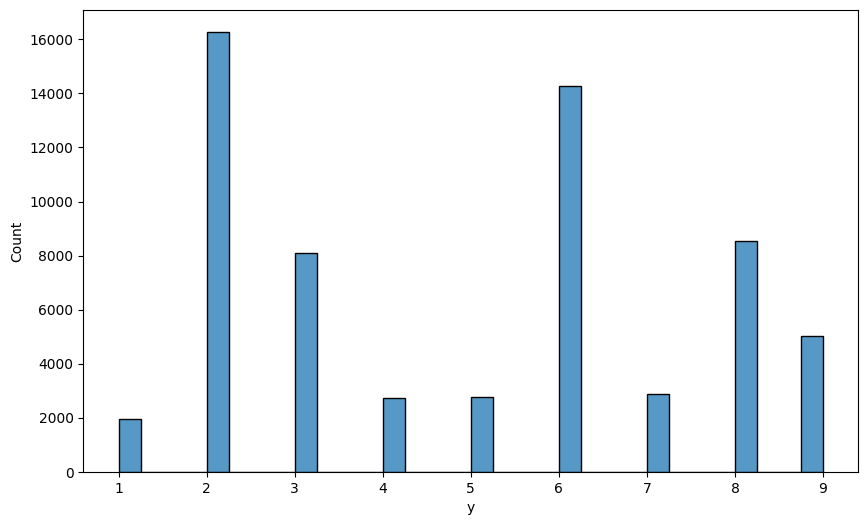

In [60]:
plt.figure(figsize=(10,6))
sns.histplot(train.y)
plt.show()

In [61]:
X_train, y_train = train.drop(["y"], axis=1), train.loc[:, "y"]
X_test = test

print(train.shape, test.shape)

(62500, 109) (150000, 108)


In [81]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_tr.shape, X_val.shape)

(46875, 108) (15625, 108)


In [82]:
smote = SMOTE(random_state=42)
X_tr_smote, y_tr_smote = smote.fit_resample(X_tr, y_tr)

In [83]:
print(Counter(y_tr_smote))

Counter({8: 12275, 7: 12275, 5: 12275, 2: 12275, 9: 12275, 1: 12275, 6: 12275, 4: 12275, 3: 12275})


In [138]:
svd = TruncatedSVD(random_state=42, n_components=10).fit(X_tr_smote)
X_tr_smote_svd = svd.transform(X_tr_smote)
X_val_svd = svd.transform(X_val)

In [139]:
logistic_regression_svd = LogisticRegression(random_state=42, penalty='l1', solver='saga').fit(X_tr_smote_svd, y_tr_smote)
lr_preds_probs_svd = logistic_regression_svd.predict_proba(X_val_svd)

In [140]:
report_log_loss(logistic_regression_svd, y_val, lr_preds_probs_svd)

log_loss of logistic_regression_svd for validation set 7.2330


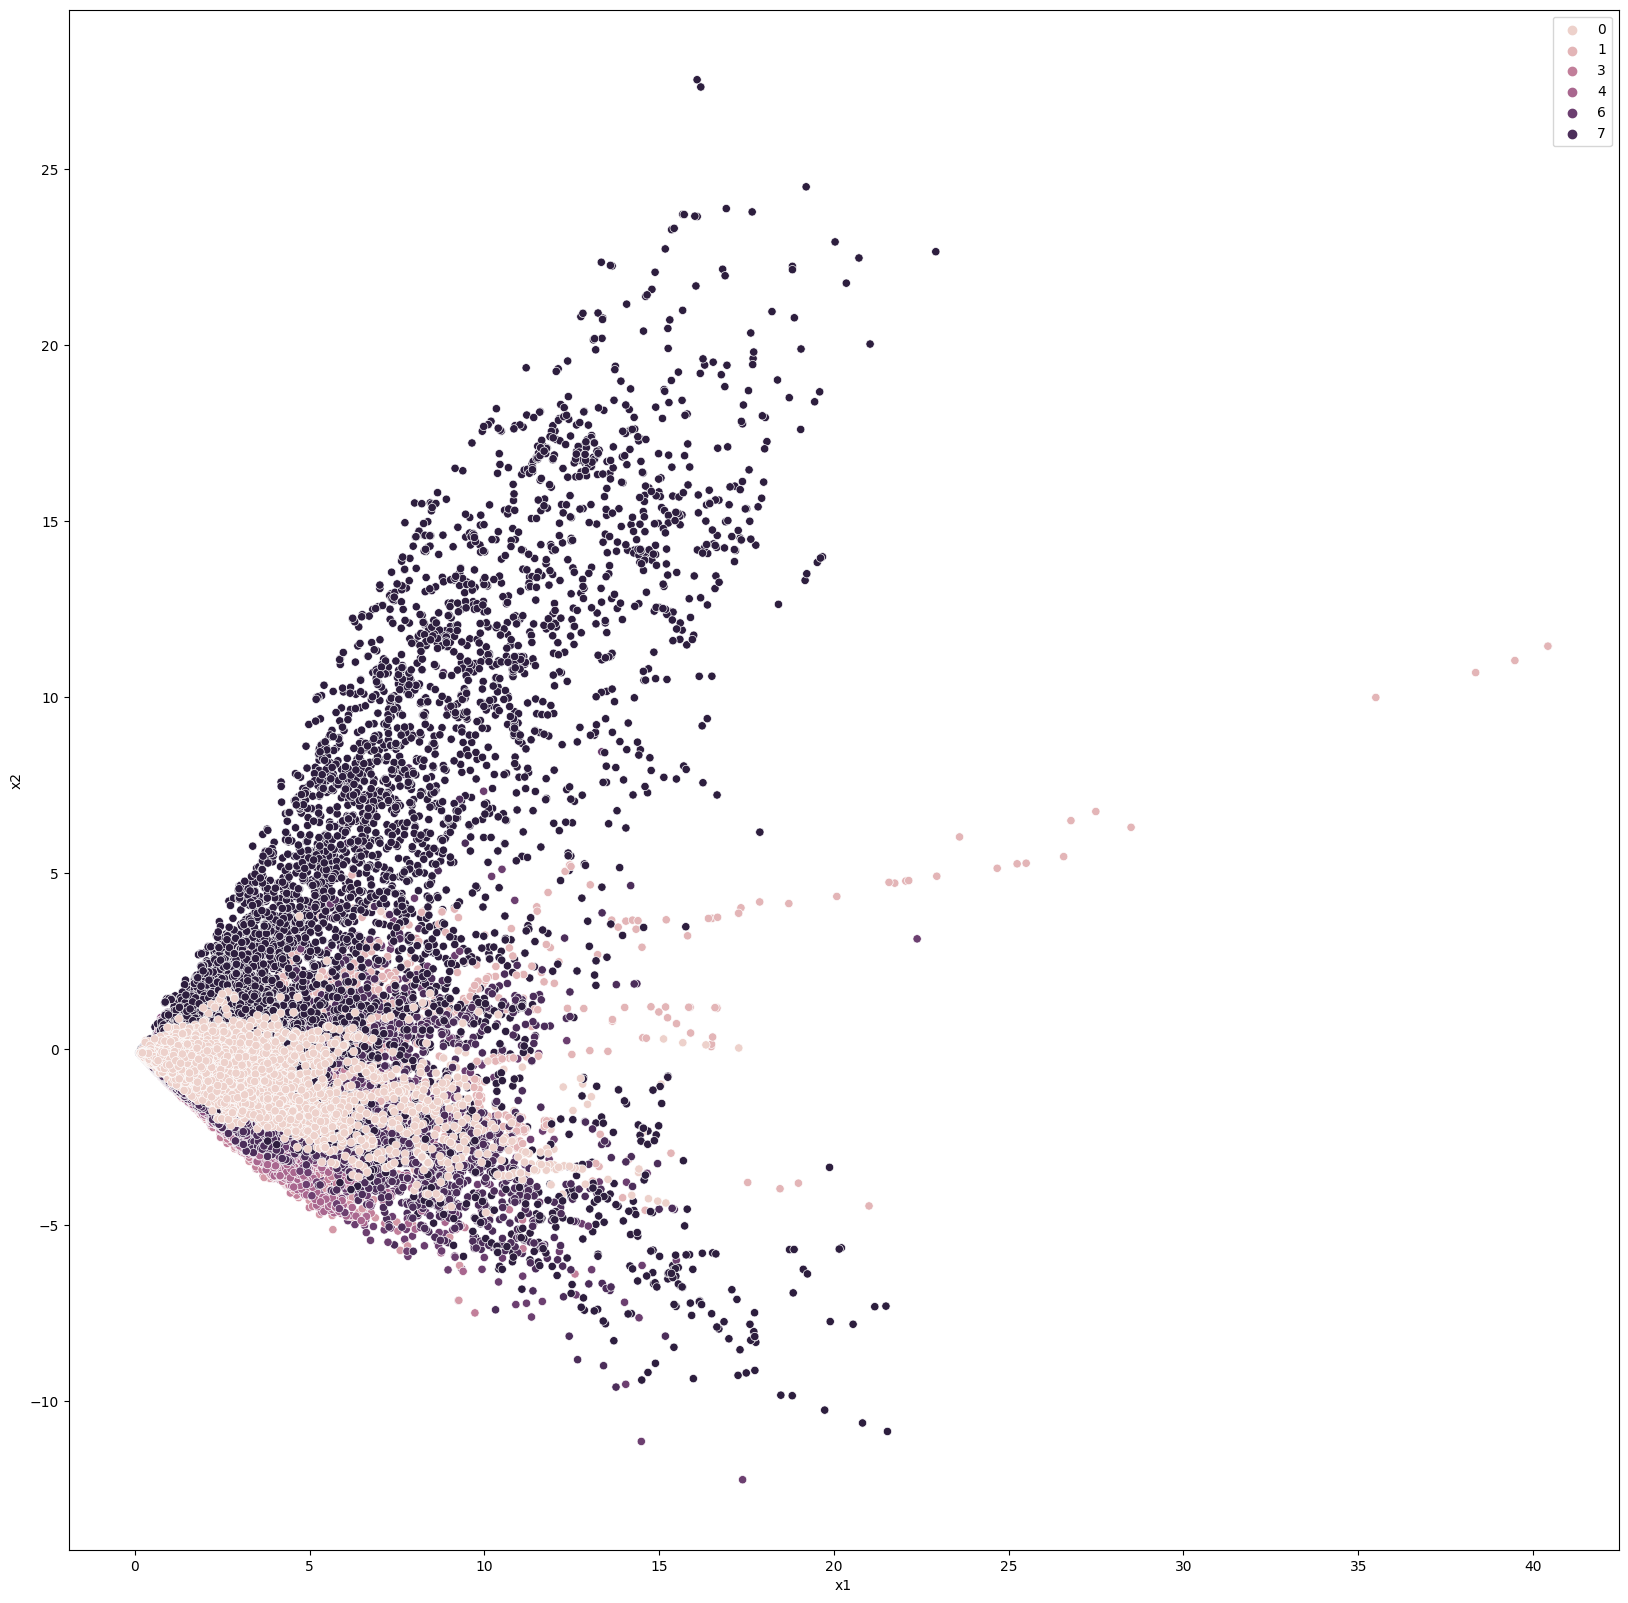

In [132]:
plotting = pd.concat([pd.DataFrame(X_tr_smote_svd, columns=["x1","x2"]), pd.Series(y_tr_smote, name="y")],axis=1)
plt.figure(figsize=(20,20))
sns.scatterplot(data=plotting, x="x1", y="x2", hue="y")
plt.legend()
plt.show()

In [69]:
logistic_regression = LogisticRegression(random_state=42, penalty='l1', solver='saga').fit(X_tr_smote, y_tr_smote)
lr_preds_probs = logistic_regression.predict_proba(X_val)

In [70]:
report_log_loss(logistic_regression, y_val, lr_preds_probs)

log_loss of logistic_regression for validation set 0.7693


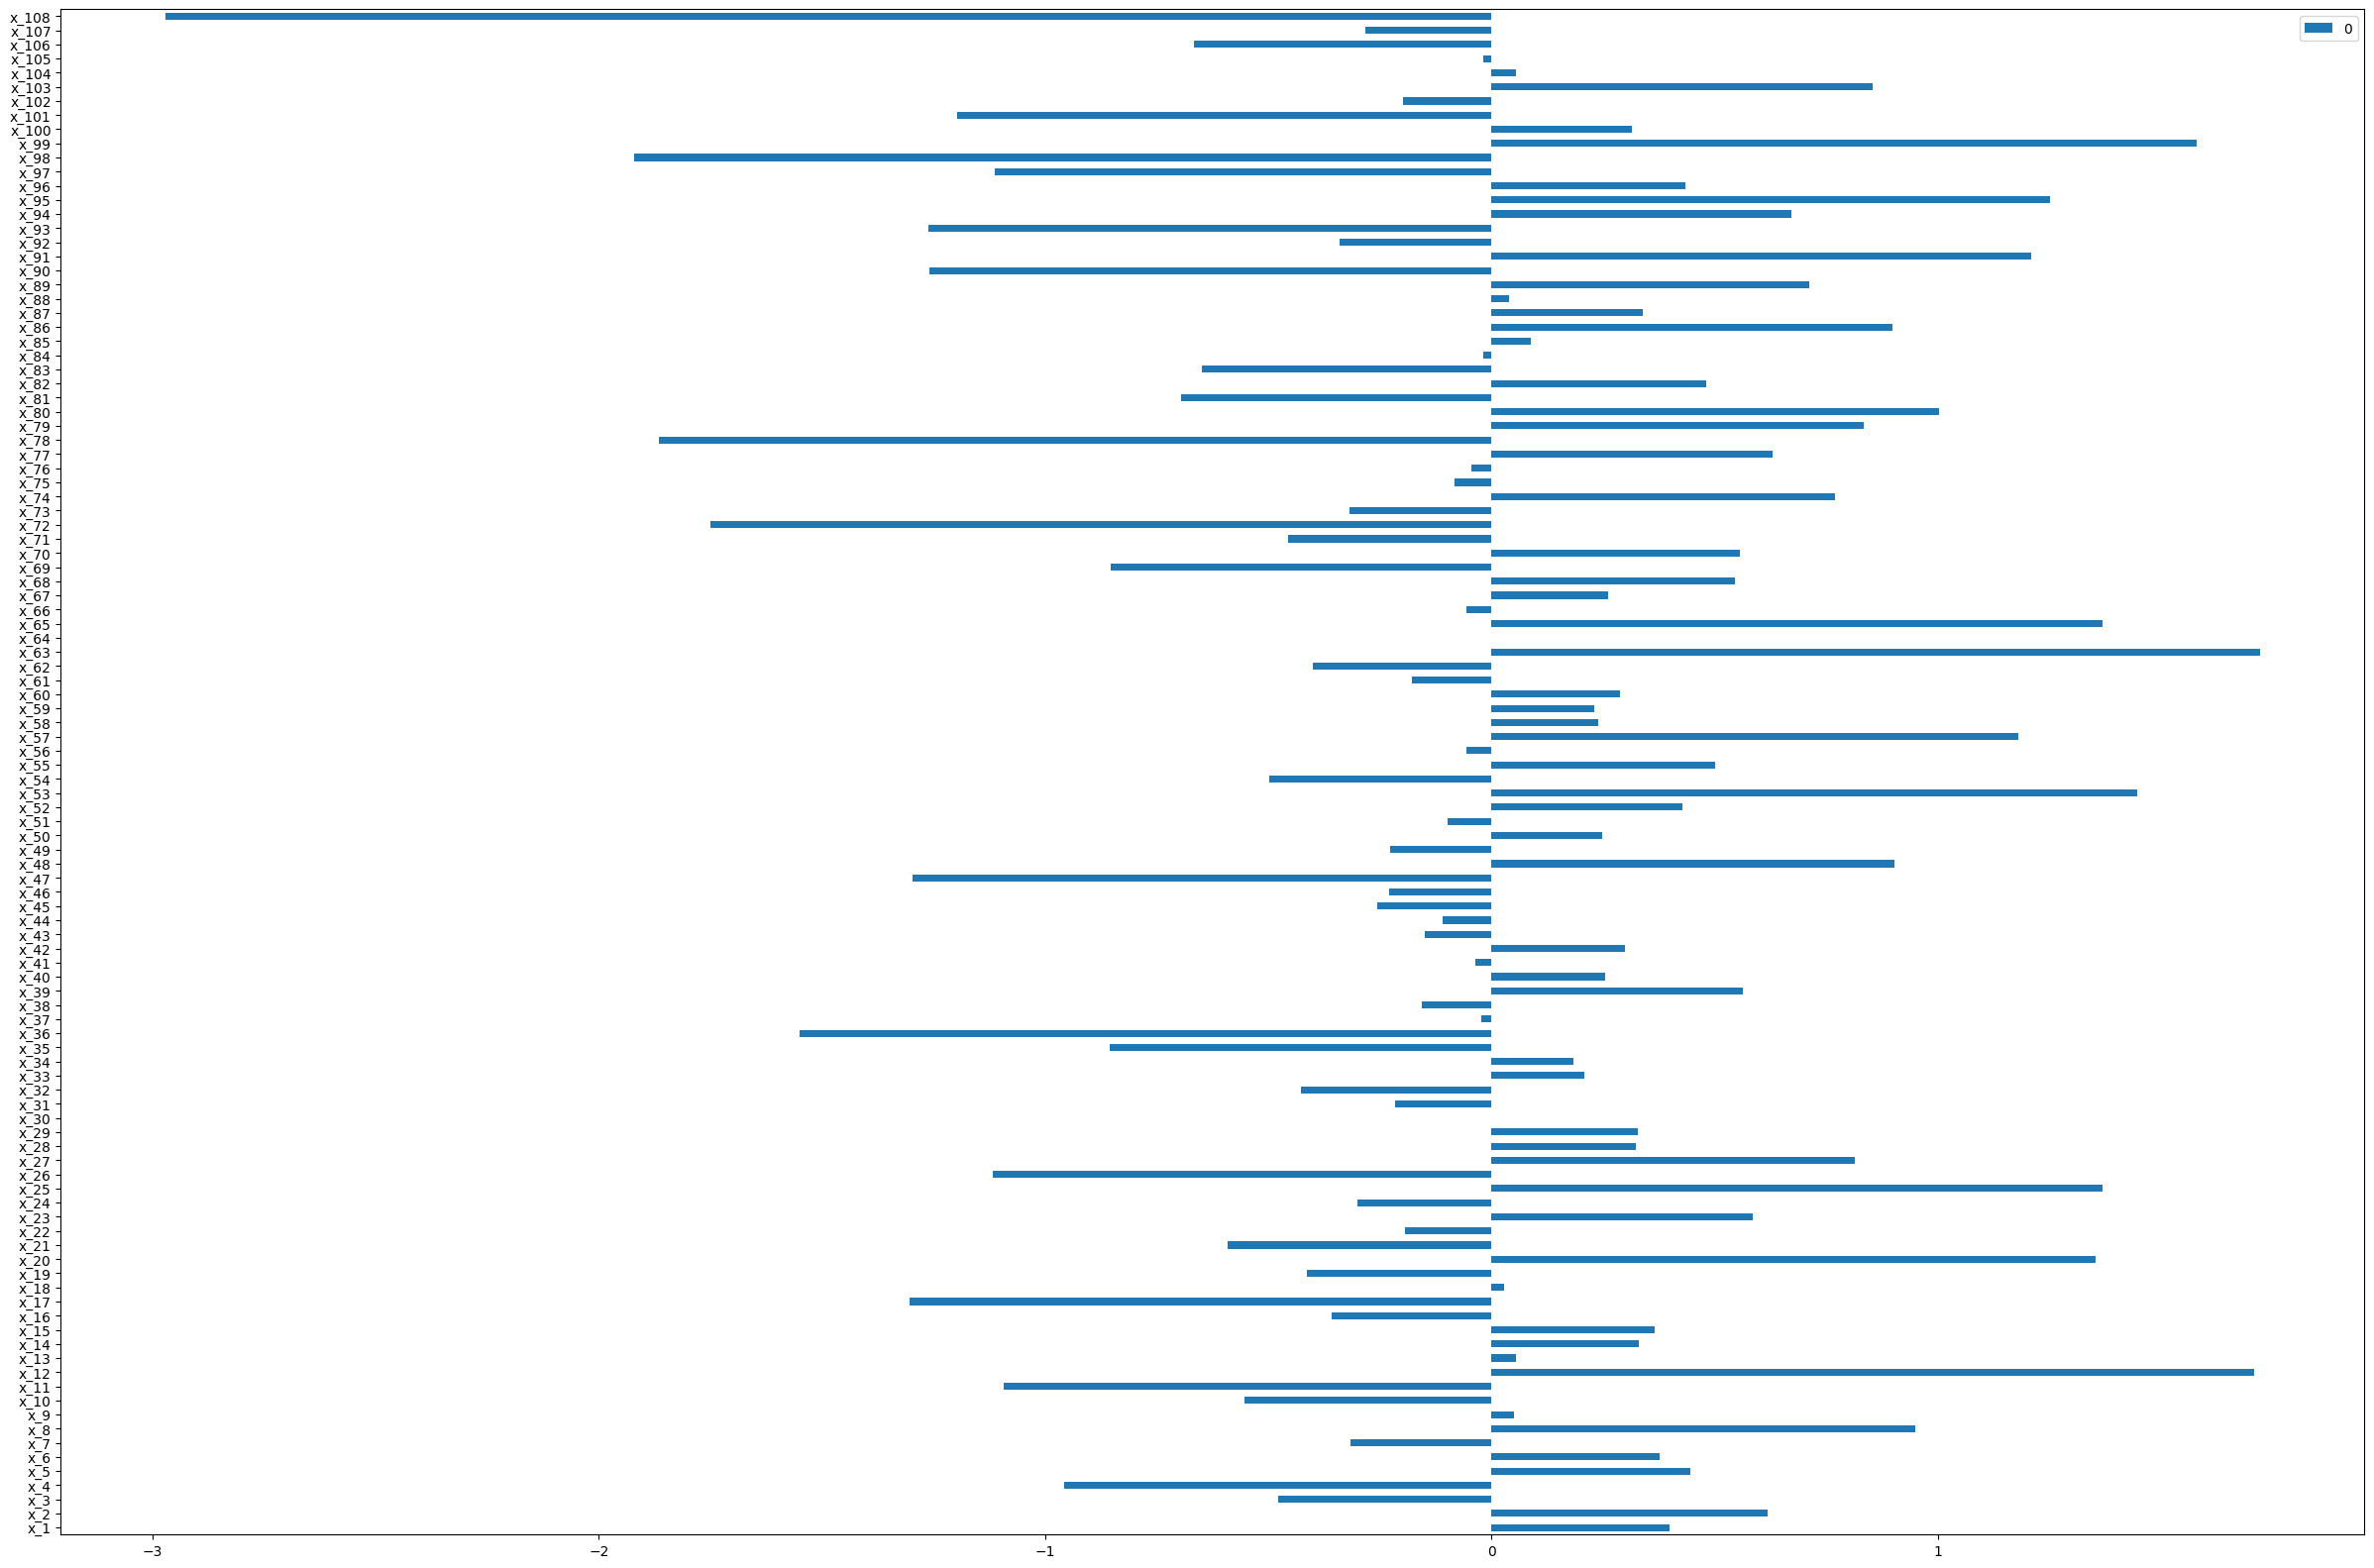

In [113]:
pd.DataFrame(logistic_regression.coef_[0,:].reshape(1,-1), columns = X_tr.columns).T.plot(kind="barh", figsize=(30,20))
plt.show()

In [ ]:
rf_clf = RandomForestClassifier(random_state=42).fit(X_tr_smote, y_tr_smote)
rf_preds_probs = rf_clf.predict_proba(X_val)

In [ ]:
report_log_loss(rf_clf, y_val, rf_preds_probs)

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth' : trial.suggest_int('max_depth', 4, 100),
        'min_samples_split' : trial.suggest_int('min_samples_split', 1, 4),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 4),
        # 'max_features': trial.suggest_categorical('max_features' ,['auto', 'sqrt'])
    }

    clf = RandomForestClassifier(random_state=42, **params).fit(X_tr_smote, y_tr_smote)
    pred_probas = clf.predict_proba(X_val)
    score = log_loss(y_val, pred_probas)
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

In [85]:
#transform 9s to 0s for xgboost

y_tr_smote = np.where(y_tr_smote==9, 0, y_tr_smote)

In [86]:
xgb_clf = xgb.XGBClassifier(random_state=42).fit(X_tr_smote, y_tr_smote)
xgb_pred_probas = xgb_clf.predict_proba(X_val)

In [87]:
report_log_loss(xgb_clf, y_val, xgb_pred_probas)

log_loss of xgb_clf for validation set 7.8032


In [117]:
pd.set_option('display.max_columns', 200)
train

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,x_59,x_60,x_61,x_62,x_63,x_64,x_65,x_66,x_67,x_68,x_69,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78,x_79,x_80,x_81,x_82,x_83,x_84,x_85,x_86,x_87,x_88,x_89,x_90,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,x_108,y
0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.2,0.0,0.2,1.8,0.0,0.0,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.2,0.8,0.0,0.0,0.0,0.0,0.6,0.2,0.0,0.0,0.2,0.0,0.0,0.4,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.2,0.4,1.0,4.6,0.6,0.4,0.0,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,1.6,0.0,0.0,0.0,0.0,0.0,0.0,1.4,0.0,0.2,0.4,0.0,0.2,0.0,0.4,0.0,1.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.8,0.0,3.8,2.2,0.0,0.2,0.2,0.6,0.0,0.4,0.0,0.2,0.4,0.0,0.6,0.0,0.8,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.4,0.0,0.2,0.2,0.0,0.4,0.4,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.4,0.0,0.0,3.2,0.0,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,1.8,1.2,0.2,0.8,0.2,0.0,0.2,0.0,0.0,0.8,0.0,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.2,1.4,0.0,0.0,0.4,0.8,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.0,0.0,0.0,0.0,0.4,0.0,1.8,0.0,0.8,0.0,0.4,0.0,3.2,0.0,0.0,0.0,0.0,0.0,0.6,0.2,0.0,0.6,0.0,0.4,0.2,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.4,0.0,0.0,0.0,0.4,0.0,0.0,0.6,0.0,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,1.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.4,0.4,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.4,0.6,0.0,0.0,0.2,0.4,0.2,0.4,0.0,0.0,0.0,0.0,0.6,0.0,0.2,0.2,0.0,0.0,1.8,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.8,0.0,0.2,1.6,0.2,0.0,1.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.2,0.0,0.0,0.2,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.2,0.0,0.0,0.0,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
62496,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,1.6,0.0,0.4,0.6,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.4,0.0